In [1]:
from google.transit import gtfs_realtime_pb2
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import zipfile
from pathlib import Path
import py7zr
import csv

## Read in GTFS Static Data

/Users/ivo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


,stop_id,stop_name,geometry
7698,9022001004501001,Gullmarsplan,POINT (18.08037 59.29942)
7699,9022001004501002,Gullmarsplan,POINT (18.08026 59.29957)
7700,9022001004503001,Globen,POINT (18.07613 59.29403)
7701,9022001004503002,Globen,POINT (18.07709 59.29421)
7702,9022001004505001,Linde,POINT (18.06386 59.29330)


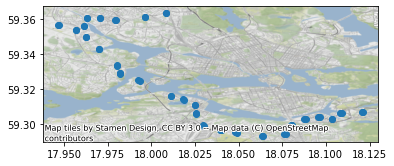

In [2]:
# Stops selected for Tvärbanan
stops = pd.read_csv('./data/2-working-data/tvarbanan-stops.csv', index_col=0)
stops.stop_id = stops.stop_id.astype(str)

# Change to GeoDataFrame
stops['geometry'] = stops.apply(lambda x: Point(x.stop_lon, x.stop_lat), axis=1)
stops = stops.drop(columns=['location_type', 'stop_lat', 'stop_lon', 'platform_code', 'parent_station'])
stops = gpd.GeoDataFrame(stops, crs='EPSG:4326')

# Plot out and show stops
ax = stops.plot()
cx.add_basemap(ax, crs=stops.crs)

stops.head()

## Read in all TripUpdates

In [3]:
# Collect all the days in the different months
days = glob("./data/0-koda-gtfs-rt/tu/*.7z")
days[:5], len(days)

(['./data/0-koda-gtfs-rt/tu/2021-10-05.7z',
  './data/0-koda-gtfs-rt/tu/2021-10-15.7z',
  './data/0-koda-gtfs-rt/tu/2021-12-01.7z',
  './data/0-koda-gtfs-rt/tu/2021-10-21.7z',
  './data/0-koda-gtfs-rt/tu/2021-10-01.7z'],
 61)

In [5]:
iterator = tqdm(days)
for day in iterator:

    path = day.split('/')[4]
    out = f"""TU-{path[:4]}{path[5:7]}{path[8:10]}"""
    out_path = f"""./data/3-cleaned-data/{out}.csv"""
    
    if os.path.exists(out_path):
        print(out+" exists.")
        continue
    
    with py7zr.SevenZipFile(day, 'r') as archive:
        allfiles = archive.getnames()
        targets = [f for f in allfiles if f.endswith('.pb')]
        iterator.set_description(f"""{out}: Unpacking {len(targets)} files""")
        files = archive.read(targets)

    iterator.set_description(f"""{out}: Reading""")
    tu_data = []
    for target in tqdm(targets, leave=False):

        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(files[target].read())

        for e in feed.entity: 
            tu_data += [
                (e.trip_update.timestamp, 
                 e.trip_update.trip.trip_id,
                 e.trip_update.trip.schedule_relationship,
                 stop_update.stop_id,
                 stop_update.arrival.time, 
                 stop_update.arrival.delay, 
                 stop_update.departure.time,
                 stop_update.departure.delay)
                for stop_update in e.trip_update.stop_time_update
                if stop_update.stop_id in stops.stop_id.to_list()
        ]
    
    iterator.set_description(f"""{out}: Writing CSV with {len(tu_data)} lines""")
    # Incorporate collected data into DataFrame.
    tu_df = pd.DataFrame(tu_data, columns=['timestamp', 'trip_id', 'rel', 'stop_id', 
                                        'arrival_ts', 'arrival_delay', 
                                        'departure_ts', 'departure_delay'])

    tu_df.to_csv(out_path)
    
    del tu_df
    del tu_data

  0%|          | 0/61 [00:00<?, ?it/s]

TU-20211005 exists.
TU-20211015 exists.
TU-20211201 exists.
TU-20211021 exists.
TU-20211001 exists.
TU-20211025 exists.
TU-20211011 exists.
TU-20211024 exists.
TU-20211010 exists.
TU-20211004 exists.
TU-20211014 exists.
TU-20211020 exists.
TU-20211101 exists.
TU-20211111 exists.
TU-20211125 exists.
TU-20211105 exists.
TU-20211121 exists.
TU-20211115 exists.
TU-20211104 exists.
TU-20211130 exists.
TU-20211120 exists.
TU-20211114 exists.
TU-20211110 exists.
TU-20211124 exists.
TU-20211107 exists.
TU-20211009 exists.
TU-20211123 exists.
TU-20211019 exists.
TU-20211117 exists.
TU-20211103 exists.
TU-20211113 exists.
TU-20211029 exists.
TU-20211127 exists.
TU-20211102 exists.
TU-20211112 exists.
TU-20211028 exists.
TU-20211126 exists.
TU-20211106 exists.
TU-20211008 exists.
TU-20211122 exists.
TU-20211018 exists.
TU-20211116 exists.
TU-20211003 exists.
TU-20211129 exists.
TU-20211027 exists.
TU-20211013 exists.
TU-20211007 exists.
TU-20211109 exists.
TU-20211119 exists.
TU-20211017 exists.
